In [1]:
import numpy as np
import awkward0
import tensorflow as tf
import os
from tensorflow import keras
from matplotlib import pyplot as plt

2023-04-08 07:41:39.810349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 07:41:40.690505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
cd ..

/home/rd804/discriminator-metric


In [3]:
from scripts.particlenet_models import get_particle_net, get_particle_net_lite
from scripts.particlenet_utils import *

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

3 Physical GPUs, 3 Logical GPUs


2023-04-08 03:01:21.461348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8747 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0, compute capability: 6.0
2023-04-08 03:01:21.462144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13877 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:81:00.0, compute capability: 6.0
2023-04-08 03:01:21.462709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 12541 MB memory:  -> device: 2, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0


In [4]:
exp_name = ''

In [7]:
train_dataset = Dataset('data/converted/train_file.awkd', data_format='channel_last')
val_dataset = Dataset('data/converted/val_file.awkd', data_format='channel_last')

[2023-04-08 03:01:54,318] INFO: Start loading file data/converted/train_file.awkd
[2023-04-08 03:01:57,749] INFO: Finished loading file data/converted/train_file.awkd
[2023-04-08 03:01:57,754] INFO: Start loading file data/converted/val_file.awkd
[2023-04-08 03:01:58,915] INFO: Finished loading file data/converted/val_file.awkd


In [33]:
from tensorflow import keras
from scripts.particlenet_models import get_particle_net, get_particle_net_lite

In [34]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
num_classes = train_dataset.y.shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
if 'lite' in model_type:
    model = get_particle_net_lite(2, input_shapes)
else:
    model = get_particle_net(2, input_shapes)

In [35]:
train_dataset.y.shape

(121793, 2)

In [36]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 2

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
#model.summary()

[2023-04-07 07:44:28,809] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 100, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 100, 1)      0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_2 (TFOpLambda)         (None, 100, 1)       0           ['tf.math.not_equal_1[0][0]']    
                                                                                                  
 tf.math.equal_1 (TFOpLambda)   (None, 100, 1)       0           ['tf.cast_2[0][0]']    

In [39]:
# Prepare model model saving directory.
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

class epoch_save(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.save(filepath.format(epoch=epoch, **logs))
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

(121793, 100, 2)

In [41]:
train_dataset.shuffle()
model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=1, # --- train only for 1 epoch here for demonstration ---
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks)

[2023-04-07 07:44:44,237] INFO: Learning rate: 0.001000
2023-04-07 07:44:50.210582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-07 07:44:52.073072: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fbff40e9f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-07 07:44:52.073120: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-04-07 07:44:52.073134: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-04-07 07:44:52.073145: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (2): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-04-07 07:44:52.081760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to 

      0/Unknown - 53s 0s/sample - loss: 0.6933 - accuracy: 0.5104

2023-04-07 07:45:37.871608: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


      0/Unknown - 54s 0s/sample - loss: 0.6932 - accuracy: 0.5104WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2023-04-07 07:45:52,880] WARNING: Can save best model only with val_acc available, skipping.


119/119 [==============================] - 69s 577ms/sample - loss: 0.6932 - accuracy: 0.5104 - val_loss: 0.6929 - val_accuracy: 0.5087 - lr: 0.0010


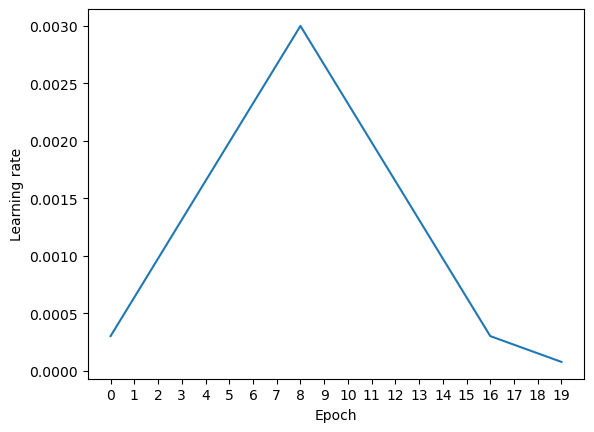

In [4]:
epochs = list(range(20))
lr_rate = [lr_schedule(epoch) for epoch in epochs]

plt.plot(epochs, lr_rate)
plt.xticks(epochs)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()


In [10]:
epoch = 10
3 * 1e-3 - (3 * 1e-3 - 3 * 1e-4) * (epoch - 8) / 8

0.002325

In [9]:
epochs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]